<a href="https://colab.research.google.com/github/antonivin/Object_Detection_PyTorch/blob/main/Kangaroo_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/antonivin/Object_Detection_PyTorch.git

Cloning into 'Object_Detection_PyTorch'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 331 (delta 5), reused 13 (delta 3), pack-reused 309
Receiving objects: 100% (331/331), 80.46 MiB | 47.79 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [ ]:
import torch 
print(torch.__version__) 

1.8.1+cu101


In [ ]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 21980, done.
remote: Counting objects: 100% (2761/2761), done.
remote: Compressing objects: 100% (623/623), done.
remote: Total 21980 (delta 2155), reused 2624 (delta 2070), pack-reused 19219
Receiving objects: 100% (21980/21980), 22.11 MiB | 18.81 MiB/s, done.
Resolving deltas: 100% (16216/16216), done.


In [ ]:
!cp /content/vision/references/detection/transforms.py /content
!cp /content/vision/references/detection/utils.py /content

In [ ]:
import torch
import os
import torchvision
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from pylab import *

import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

import glob
import os

image_size = (224,224)

In [ ]:
class kangaroo(Dataset):
    
    def __init__(self, path, transform):
        image_dir = path + '/Object_Detection_PyTorch/kangaroo/images/' 
        annotation_dir = path + '/Object_Detection_PyTorch/kangaroo/pascal/'
        self.transform = transform 
        self.image_names = os.listdir(image_dir)
        self.image_names.sort()
        self.image_names = [os.path.join(image_dir,image_name) for image_name in self.image_names]
        self.annotation_names = os.listdir(annotation_dir)
        self.annotation_names.sort()
        self.annotation_names = [os.path.join(annotation_dir,annotation_name) for annotation_name in self.annotation_names]
     
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img = Image.open(image_name)
        w,h = img.size
        img = img.resize(image_size)
        annotation_name = self.annotation_names[idx]
        annotation_tree = ET.parse(annotation_name, ET.XMLParser(encoding='utf-8'))
        classes = annotation_tree.find("object").find("name").text 
        num_objs = 1
        boxes = []
        bndbox_xml = annotation_tree.find("object").find("bndbox")
        xmin = int(bndbox_xml.find('xmin').text)
        ymin = int(bndbox_xml.find('ymin').text)
        xmax = int(bndbox_xml.find('xmax').text)
        ymax = int(bndbox_xml.find('ymax').text)
        boxes.append([xmin*224/w,ymin*224/h,xmax*224/w,ymax*224/h])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        if self.transform is not None:
            img, target = self.transform(img, target)
        #img /=255
        return img, target
    
    def __len__(self):
        return len(self.image_names)

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [ ]:
path = '/content' 
dataset = kangaroo(path, transform = get_transform(True))
print(len(dataset))

139


In [ ]:
train_set = int(0.8 * len(dataset)) 
val_set = len(dataset) - train_set 
print(train_set)
print(val_set)
batch_size = 3
train_data, val_data = torch.utils.data.random_split(dataset, [train_set, val_set])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
validationloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

111
28


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model.train()
num_epochs = 10
count = 0
acc_loss = 0
for i in range(num_epochs):
  for img,targets in trainloader:
    img = list(image.to(device) for image in img)
    target = [{k:v.to(device) for k,v in t.items()} for t in targets]
    loss_dict = model(img,target)
    loss = sum(loss for loss in loss_dict.values())
    loss_val = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count = count + 1
    acc_loss = acc_loss + loss_val
    if (count %10 == 0):
      print("Loss at iter "+str(count)+":",acc_loss/10)
      acc_loss = 0
  print("Epoch "+str(i+1)+" Loss:",loss_val)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


Loss at iter 10: 0.4562783658504486
Loss at iter 20: 0.3146048426628113
Loss at iter 30: 0.28195149898529054
Epoch 1 Loss: 0.1858280450105667
Loss at iter 40: 0.20362043529748916
Loss at iter 50: 0.22642258554697037
Loss at iter 60: 0.22102208137512208
Loss at iter 70: 0.20190530121326447
Epoch 2 Loss: 0.20441418886184692
Loss at iter 80: 0.17972342073917388
Loss at iter 90: 0.193060702085495
Loss at iter 100: 0.19879119396209716
Loss at iter 110: 0.17462323904037474
Epoch 3 Loss: 0.1131579801440239
Loss at iter 120: 0.15878926292061807
Loss at iter 130: 0.1657603994011879
Loss at iter 140: 0.1631977766752243
Epoch 4 Loss: 0.104529969394207
Loss at iter 150: 0.141124876588583
Loss at iter 160: 0.12752290740609168
Loss at iter 170: 0.14023931100964546
Loss at iter 180: 0.1372407279908657
Epoch 5 Loss: 0.11456477642059326
Loss at iter 190: 0.12248613387346267
Loss at iter 200: 0.12367550358176231
Loss at iter 210: 0.10470490157604218
Loss at iter 220: 0.11760823503136635
Epoch 6 Loss: 0.

In [ ]:
torch.save(model.state_dict(), 'kangaroo_fasterrcnn_resnet50.pth')

In [ ]:
model.eval()
img,targets = next(iter(validationloader))
img = list(image.to(device) for image in img)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
output = model(img)
print(output)

[{'boxes': tensor([[148.1480, 109.8235, 200.6528, 201.7148],
        [ 99.3570, 105.9649, 201.8610, 195.2110]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8859, 0.1606], device='cuda:0', grad_fn=<IndexBackward>)}, {'boxes': tensor([[ 25.4952, 126.6394,  79.5992, 205.9636],
        [ 78.8305, 115.2327, 116.1376, 168.1604],
        [141.2787, 134.0977, 187.2272, 184.9277],
        [112.8444,  70.2477, 147.9005, 187.6582],
        [ 34.5910, 122.7776,  48.2453, 162.6802],
        [ 76.8866,  77.1077, 140.0333, 183.8297],
        [107.8000,  76.5667, 186.6840, 181.6595],
        [104.9543, 127.0780, 181.4164, 188.7979],
        [ 19.4341,  90.1468, 125.9017, 210.2482],
        [ 44.4549,  67.9587, 153.2531, 196.9359],
        [ 38.2425, 121.6217, 159.4822, 187.2219],
        [ 29.4752, 116.5835,  58.6951, 186.8856]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5488DEE110>
[[ 25.495216 126.63939   79.59923  205.96362 ]
 [ 78.83048  115.23265  116.13765  168.1604  ]
 [141.2787   134.09767  187.22719  184.92772 ]
 [112.84437   70.24767  147.90048  187.65825 ]
 [ 34.59098  122.77757   48.24529  162.68022 ]]


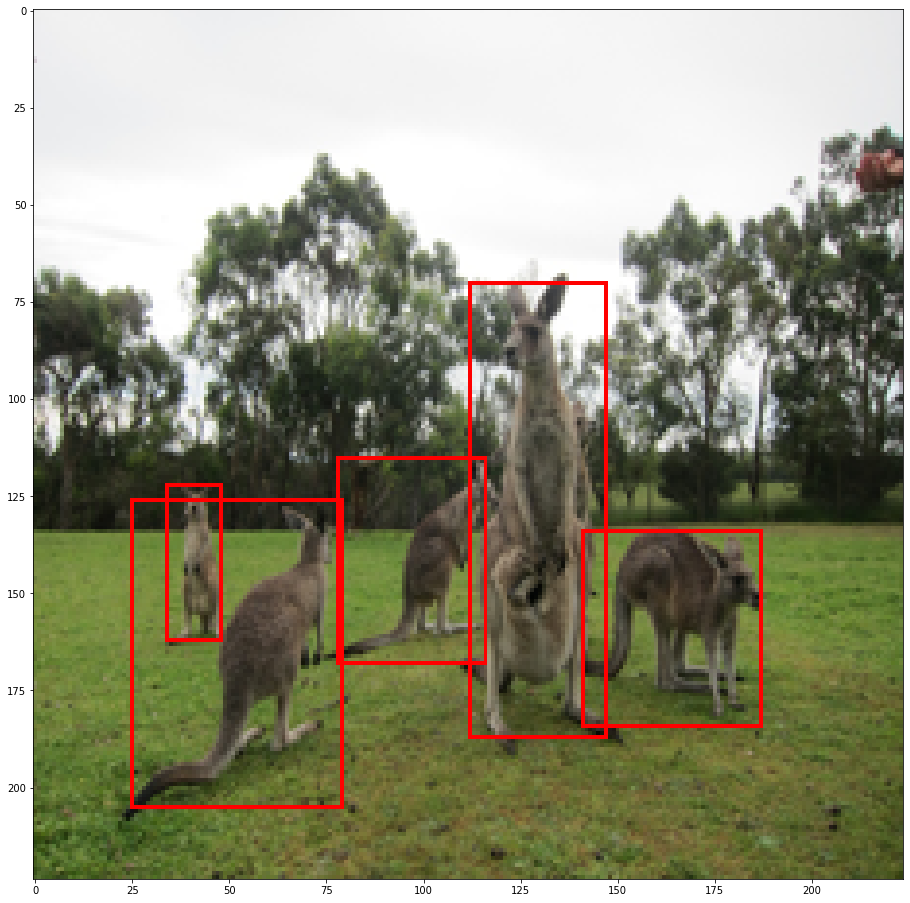

In [ ]:
from matplotlib import pyplot as plt
from PIL import *
fig, axs = plt.subplots(1, 1, figsize=(32, 16))
threshold = 0.5
sample = img[1].cpu().numpy()
res_img = Image.fromarray((255*sample).astype(np.uint8).transpose(1, 2, 0))
print(res_img)
axs.imshow(res_img)
boxes = output[1]['boxes']
scores = output[1]['scores']
boxes = boxes[scores > threshold].detach().cpu().numpy()
print(boxes)
res_img_1 = ImageDraw.Draw(res_img)
for box in boxes:
  res_img_1.rectangle([box[0], box[1], box[2], box[3]],outline = "Red",width = 1)
axs.imshow(res_img)

In [ ]:
!git commit --all

fatal: not a git repository (or any of the parent directories): .git
